# Question 2a4
Compare the accuracies of all the models from parts (1) - (3) and discuss their performances.

# Imports and Setup

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# chuanxin
%cd "../gdrive/My Drive/cz4042_assignment_2/2a" 

Mounted at /gdrive
/gdrive/My Drive/cz4042_assignment_2/2a


In [2]:
import os
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

In [3]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

inspect_index = 40

# Helper functions

### load_data(file)
Used to load in the data 

In [23]:
# Fixed, no need change
def load_data(file):
  with open(file, 'rb') as fo:
    try:
      samples = pickle.load(fo)
    except UnicodeDecodeError:  # python 3.x
      fo.seek(0)
      samples = pickle.load(fo, encoding='latin1')

  data, labels = samples['data'], samples['labels']

  data = np.array(data, dtype=np.float32) / 255
  labels = np.array(labels, dtype=np.int32)
  
  data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
  return data, labels

### make_directories()
Used to create directories that might not have been made

In [24]:
# Create folder to store histories and figures
def make_directories():
  if not os.path.exists('./histories'):
      os.mkdir('./histories')
  if not os.path.exists('./figures'):
      os.mkdir('./figures')    

### history_saver(history, filename, already_json=False)
Used to save a history object

In [25]:
# filename like 'history/model_name.json'
def history_saver(history, model_name, already_json=False):
  history_json = {}

  if already_json:
    history_json = history
  else:
    history = history.history
    for key in history.keys():
      history_json[key] = history[key]

  with open('./histories/' + model_name, 'w') as file:
    json.dump(history_json, file)

  print("History saved")

### history_loader(filename)
Used to load in a json history object

In [26]:
# filename like 'history/model_name.json'
def history_loader(model_name):
  with open('./histories/'+model_name) as json_file:
    history = json.load(json_file)
  print('History loaded')
  
  return history 

### plot_3_channel_img(np_array):

In [27]:
def plot_3_channel_img(np_array, inspect_index=None, filename=None):
  if inspect_index == None:
    inspect_index = np.random.randint(len(np_array))

  titles = ['Original', 'Red channel', 'Green channel', 'Blue channel']
  cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

  fig, axes = plt.subplots(1, 4, figsize=(32,8))
  objs = zip(axes, (np_array[inspect_index], *np_array[inspect_index].transpose(2,0,1)), titles, cmaps)

  if filename == None:
    print("index", inspect_index)

  for ax, channel, title, cmap in objs:
    ax.imshow(channel, cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
  
  if filename != None:
    fig.savefig(f'./figures/{filename}')

### plot_loss(history_json, model_name)
Plot out loss graph, and also save it

In [28]:
def plot_loss(history_json, model_name):
  train_loss = history_json['loss']
  test_loss = history_json['val_loss']
  title = 'Model name: ' + model_name + '\nloss against epochs'

  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_loss.png')
  
  plt.show()

### plot_acc(history_json, model_name)
Plot out accuracy graph, and also save it

In [29]:
def plot_acc(history_json, model_name):
  train_acc = history_json['accuracy']
  test_acc = history_json['val_accuracy']
  title = 'Model name: ' + model_name + '\naccuracy against epochs'

  plt.plot(train_acc, label='train')
  plt.plot(test_acc, label='test')
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_accuracy.png')
  
  plt.show()

### plot_activations(model, model_name, x_data, x_data_name)
Get the intermediate activations for a single x_data (one item in x_train or x_test)

In [30]:
def plot_activations(model, model_name, x_data, x_data_name):
  plot_3_channel_img(x_data, filename=f'{model_name}_{x_data_name}_source.png')

  layer_outputs = [layer.output for layer in model.layers]
  activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
  activations = activation_model.predict(x_data) 

  activation_layer_names = ['conv1', 'max1', 'conv2', 'max2']  
  activations = activations[:4]

  images_per_row = 10
  
  for layer_name, layer_activation in zip(activation_layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
      for row in range(images_per_row):
        channel_image = layer_activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image # Displays the grid 
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig(f'./figures/{model_name}_{x_data_name}_{layer_name}.png')
    plt.show()

# 2a4 - compare all models from part 2a2 and 2a3
2a1 is contained within 2a2

In [12]:
fnames_histories = next(os.walk('./histories'))[2]

histories_json = {}

for fname in fnames_histories:
  if fname.split('_model_')[0] in ['q2', 'q3']:
    histories_json[fname] = history_loader(fname)

History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded


In [13]:
def compare_test_acc(histories_json, filename, start_from_epoch=None, title=None):
  fig = plt.figure(figsize=(20,10))

  for model_name in histories_json.keys():    
    if start_from_epoch == None:
      test_acc = histories_json[model_name]['val_accuracy']
    else:
      test_acc = histories_json[model_name]['val_accuracy'][start_from_epoch:]
    plt.plot(test_acc, label=model_name)    
  
  if title == None:
    title = 'test accuracy against epochs'
    plt.title(title)
  else:
    plt.title(title)
  plt.ylabel('test accuracy')
  plt.xlabel('epochs')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

  plt.savefig(f'./figures/{filename}.png')

  plt.show()

### Compare across num_ch_c1

In [14]:
list_num_ch_c1 = [{}, {}, {}, {}, {}]

for model_name in histories_json.keys():
  for i in range(5):
    num_ch_c1 = str(20*i + 10)
    if model_name.split('_model_')[0] == 'q2' and model_name.split('_model_')[1].split('_')[0] == num_ch_c1:
      list_num_ch_c1[i][model_name] = histories_json[model_name]

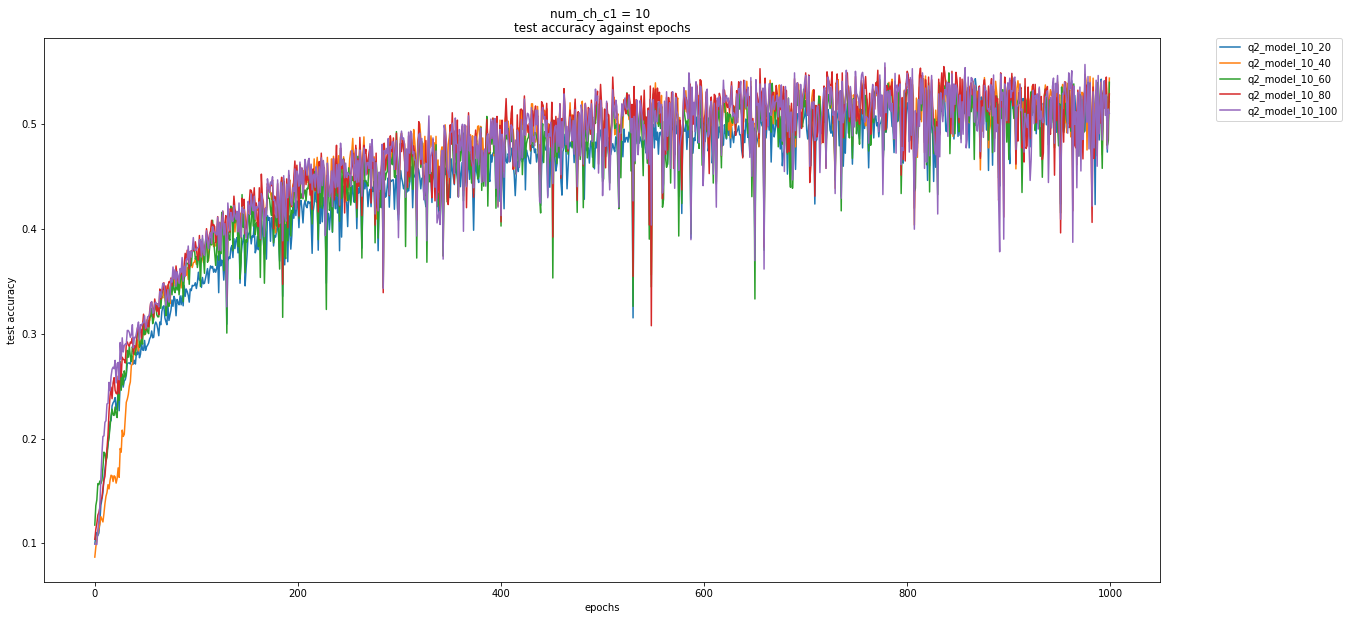

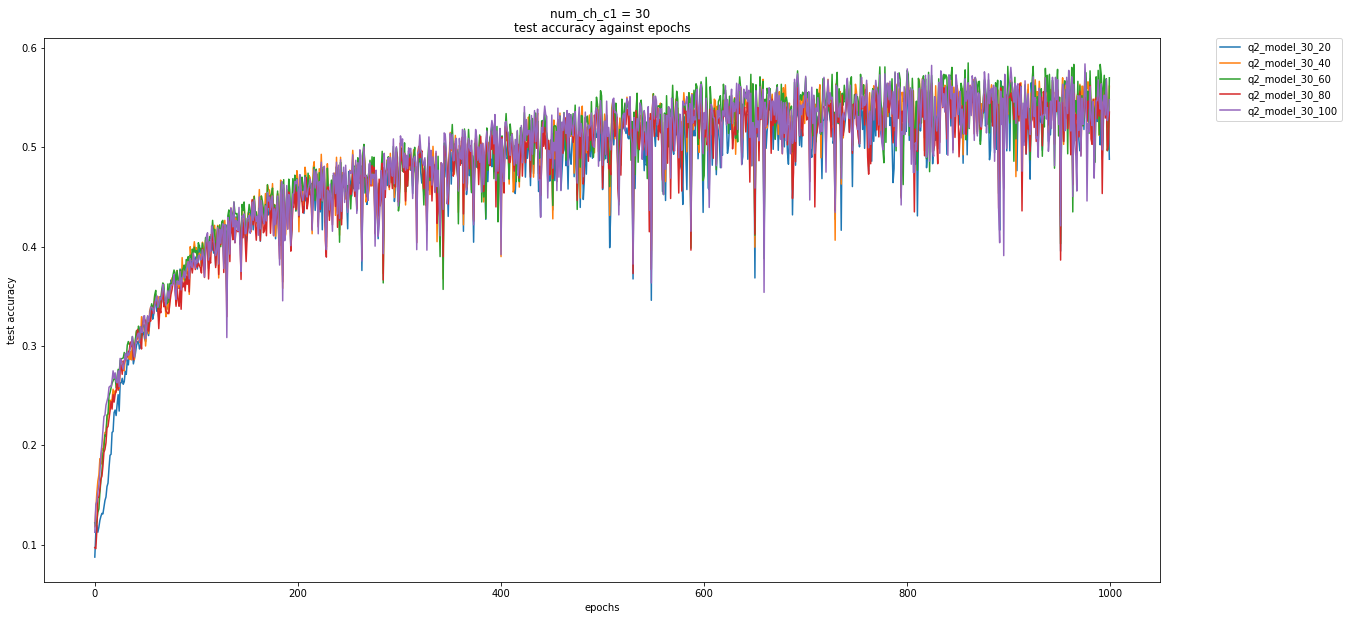

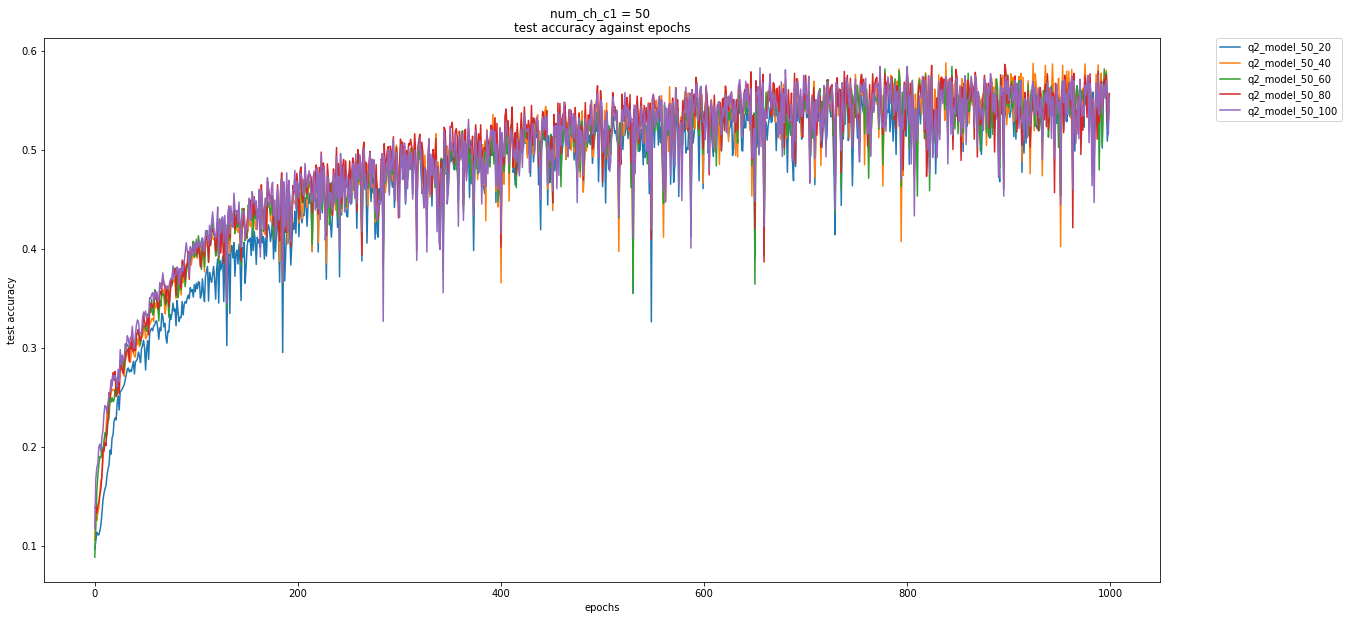

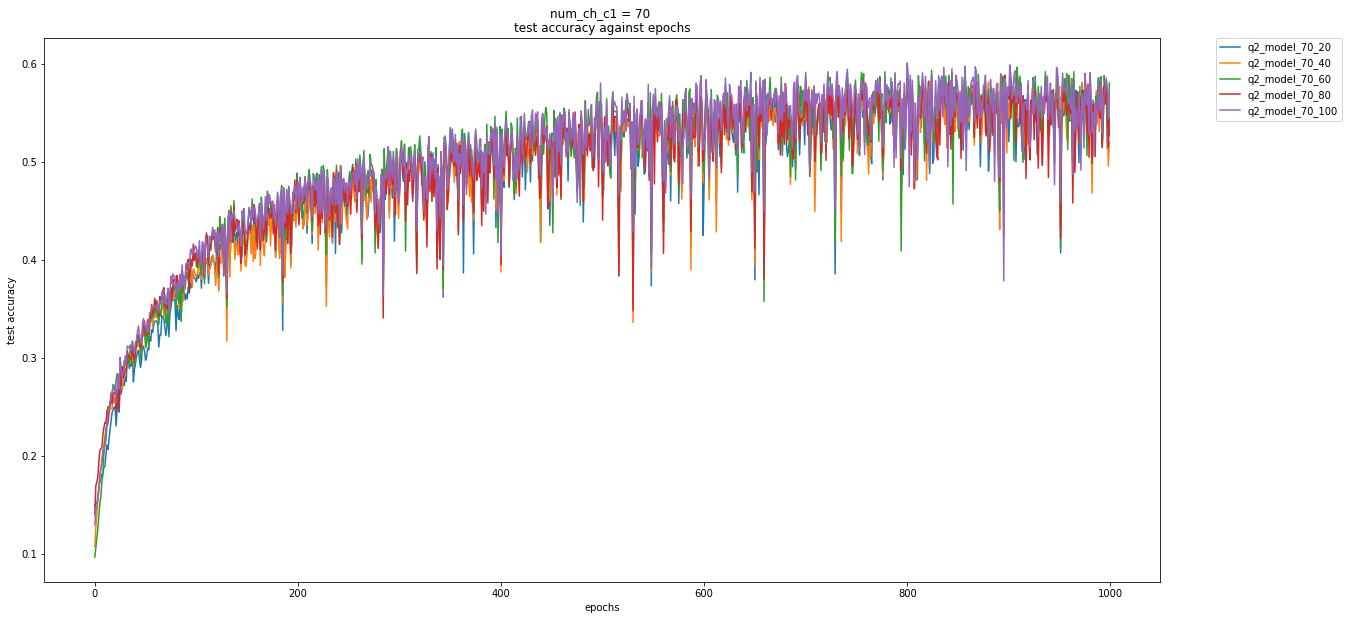

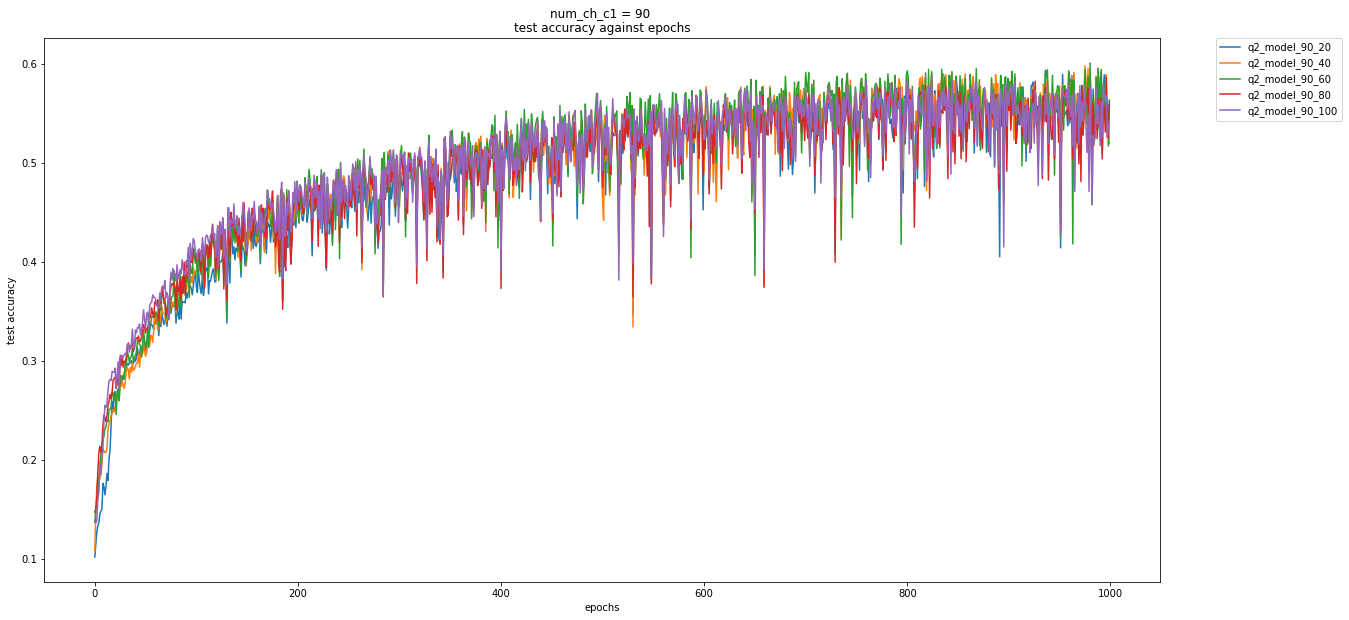

In [15]:
for i in range(5):
  num_ch_c1 = str(20*i + 10)
  filename = 'q4_compare_test_acc_num_ch_c1_' + num_ch_c1
  title = f'num_ch_c1 = {num_ch_c1} \ntest accuracy against epochs'
  compare_test_acc(list_num_ch_c1[i], filename, title=title)

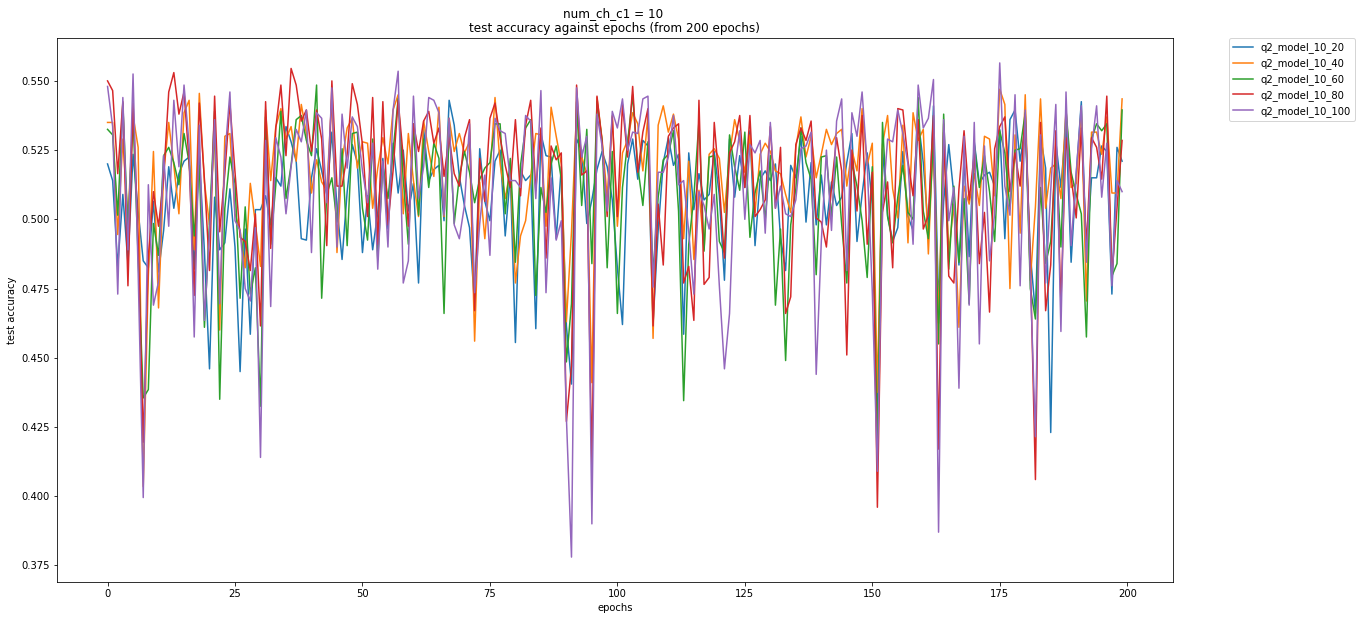

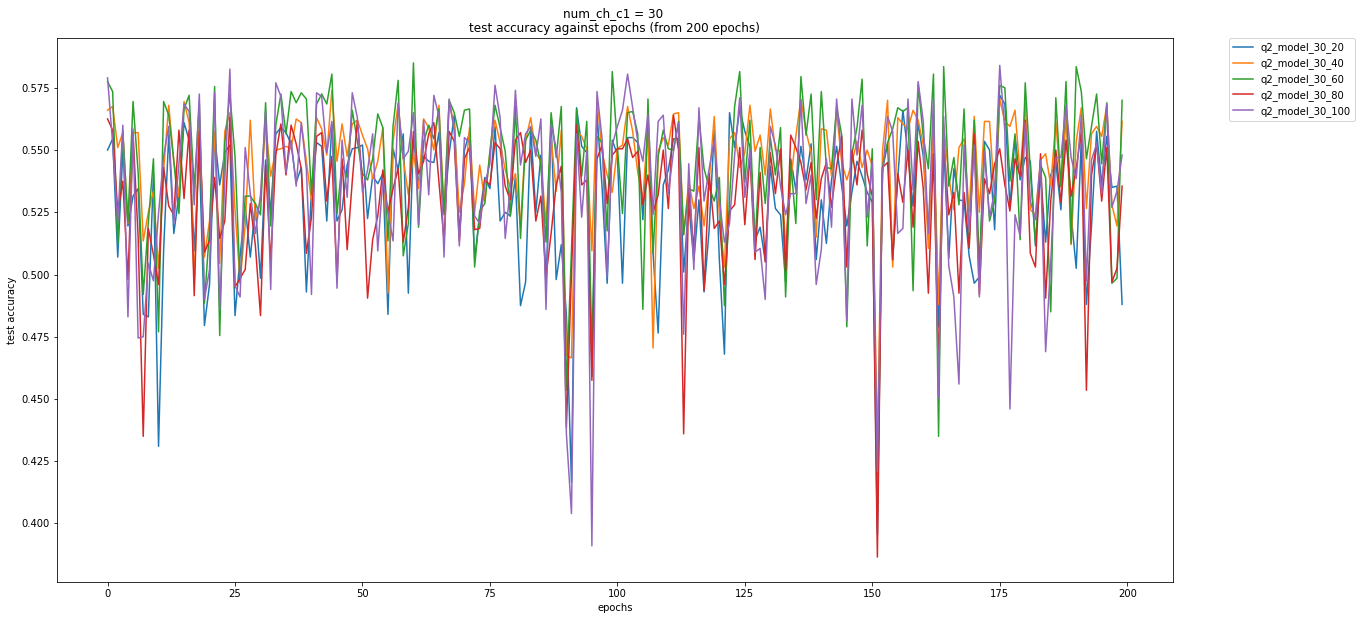

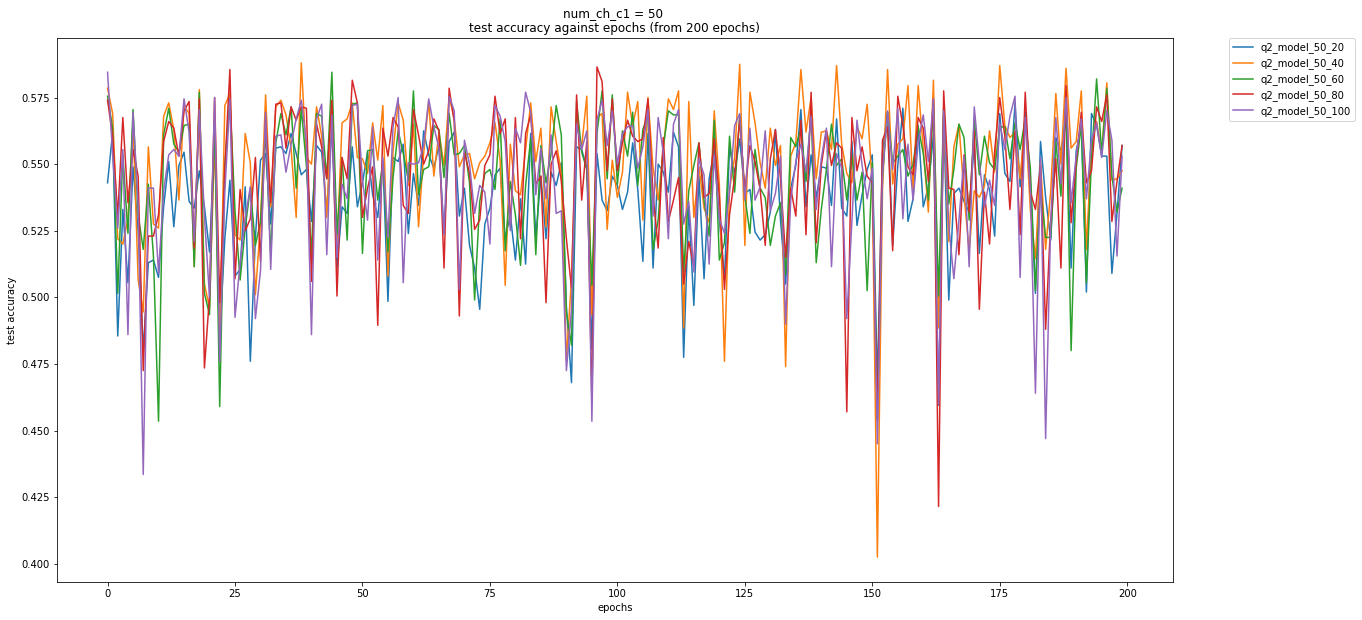

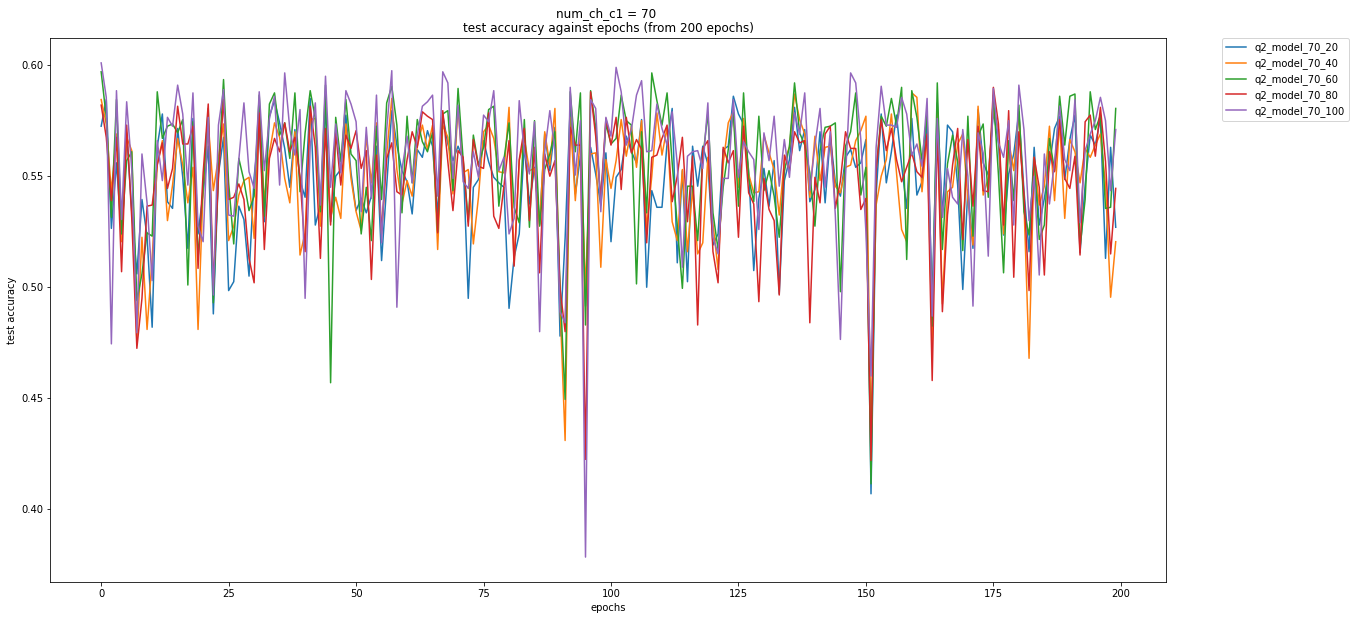

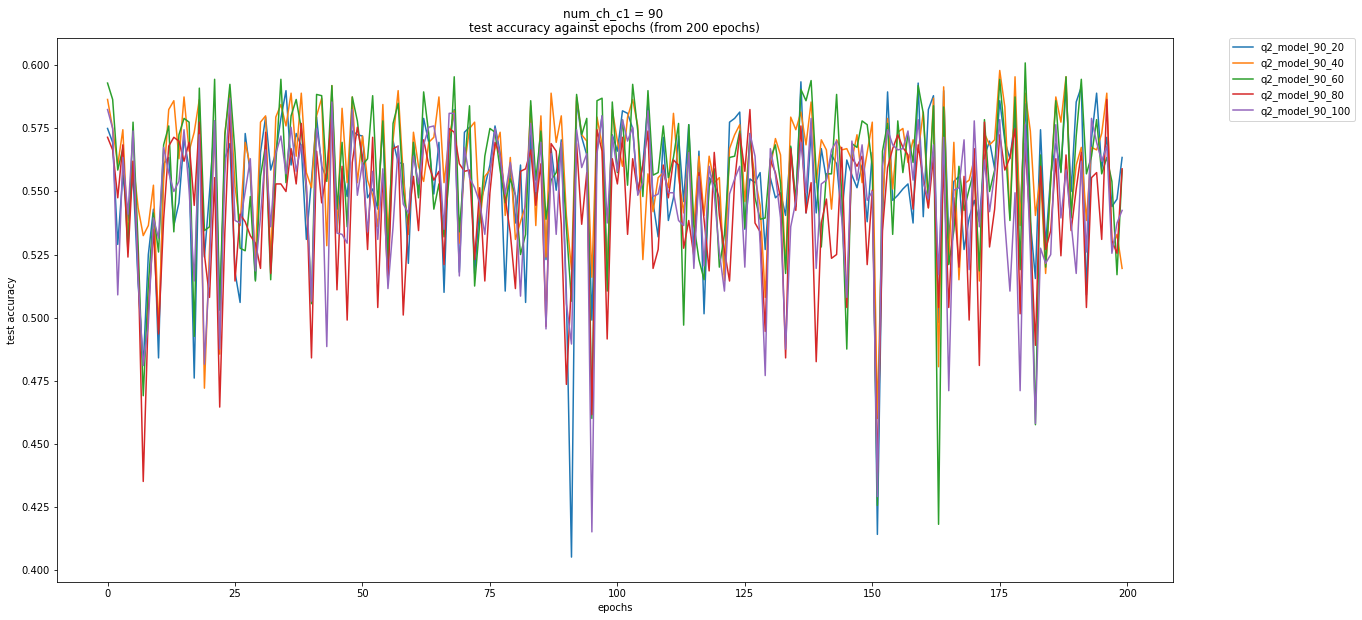

In [16]:
for i in range(5):
  num_ch_c1 = str(20*i + 10)
  filename = 'q4_compare_test_acc_num_ch_c1_' + num_ch_c1 + '_from_epoch_800'
  title = f'num_ch_c1 = {num_ch_c1} \ntest accuracy against epochs (from 200 epochs)'
  compare_test_acc(list_num_ch_c1[i], filename, 800, title=title)

### Compare across num_ch_c2

In [17]:
list_num_ch_c2 = [{}, {}, {}, {}, {}]

for model_name in histories_json.keys():
  for i in range(5):
    num_ch_c2 = str(20*i + 20)
    if model_name.split('_model_')[0] == 'q2' and model_name.split('_model_')[1].split('_')[1] == num_ch_c2:
      list_num_ch_c2[i][model_name] = histories_json[model_name]

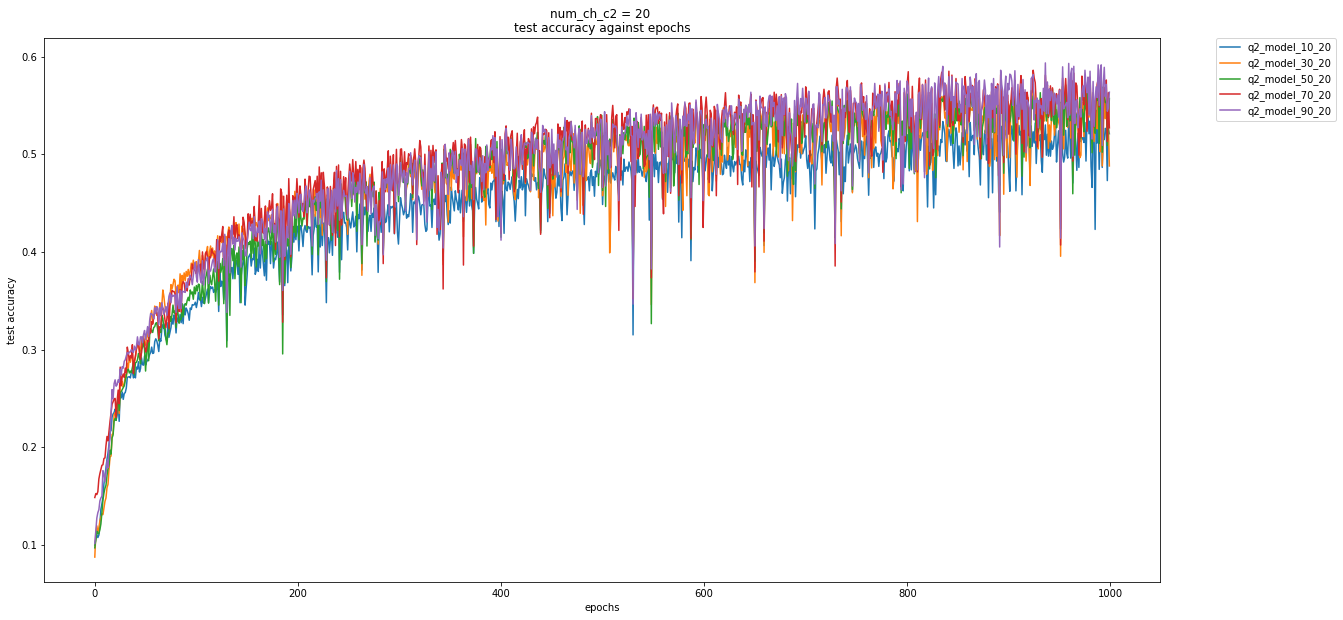

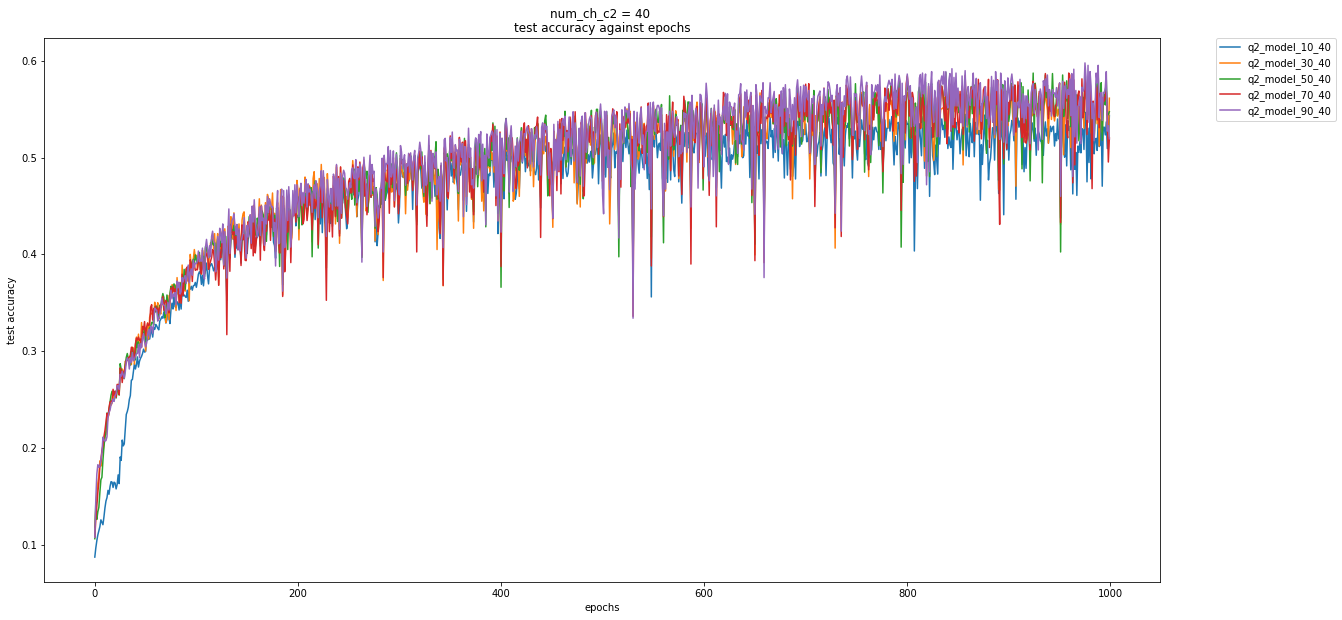

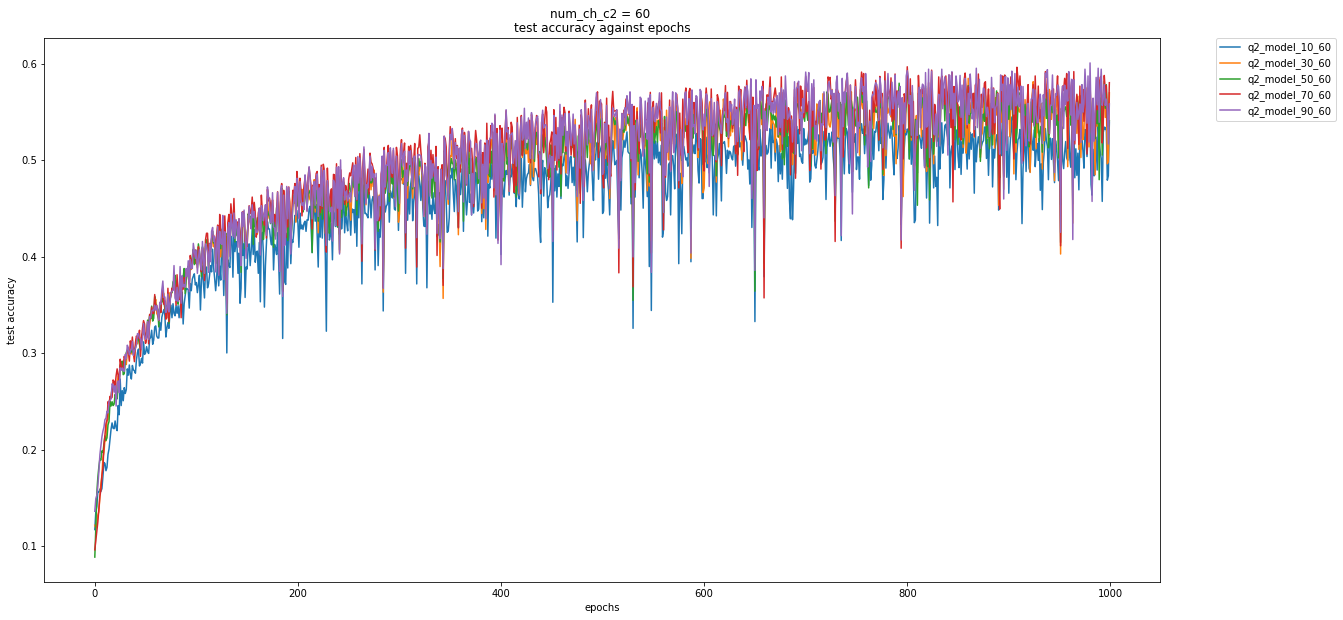

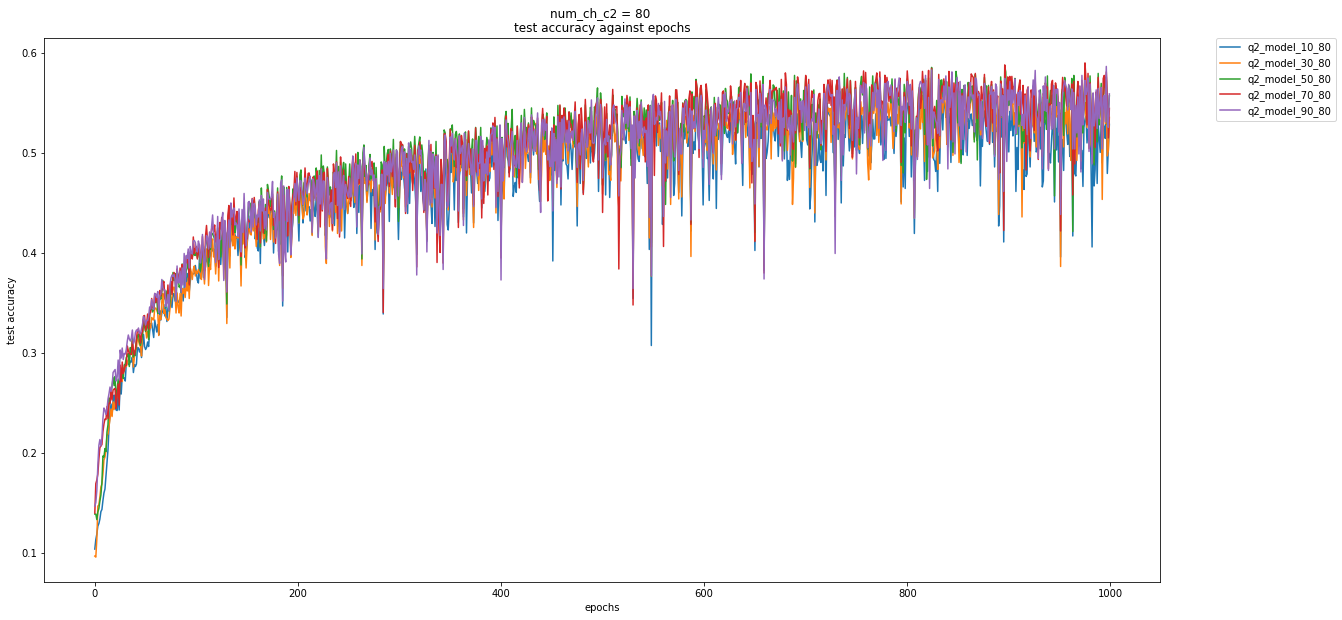

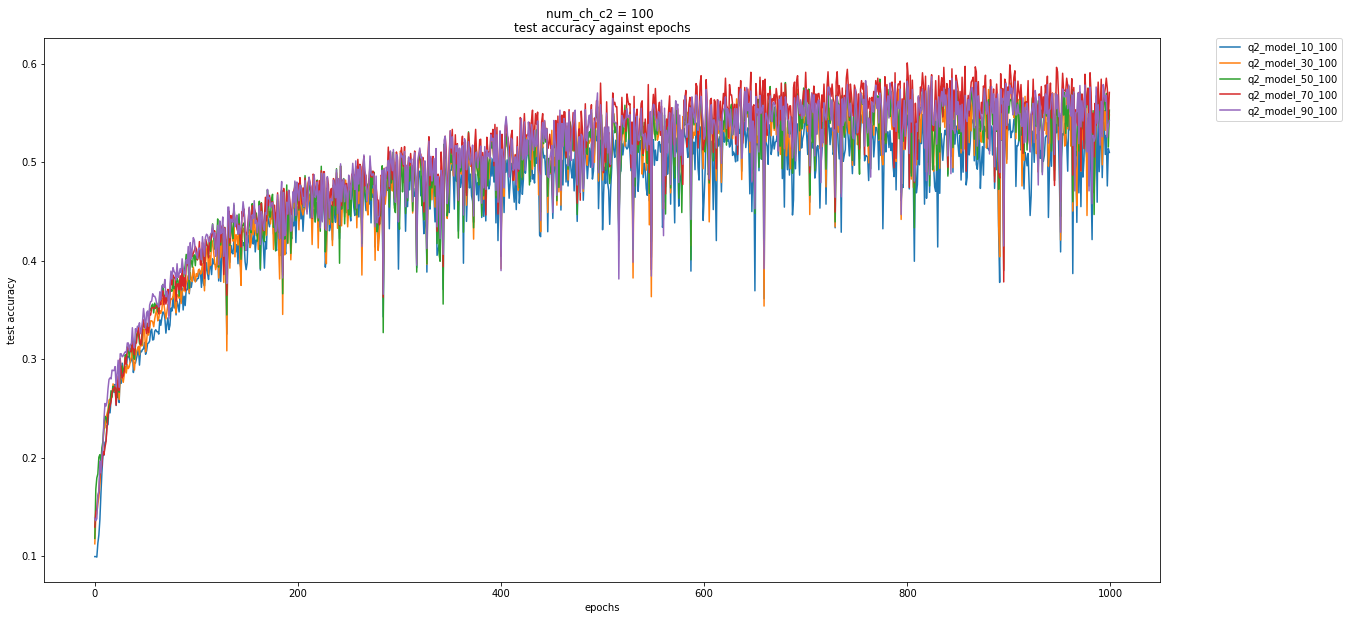

In [18]:
for i in range(5):
  num_ch_c2 = str(20*i + 20)
  filename = 'q4_compare_test_acc_num_ch_c2_' + num_ch_c2
  title = f'num_ch_c2 = {num_ch_c2} \ntest accuracy against epochs'
  compare_test_acc(list_num_ch_c2[i], filename, title=title)

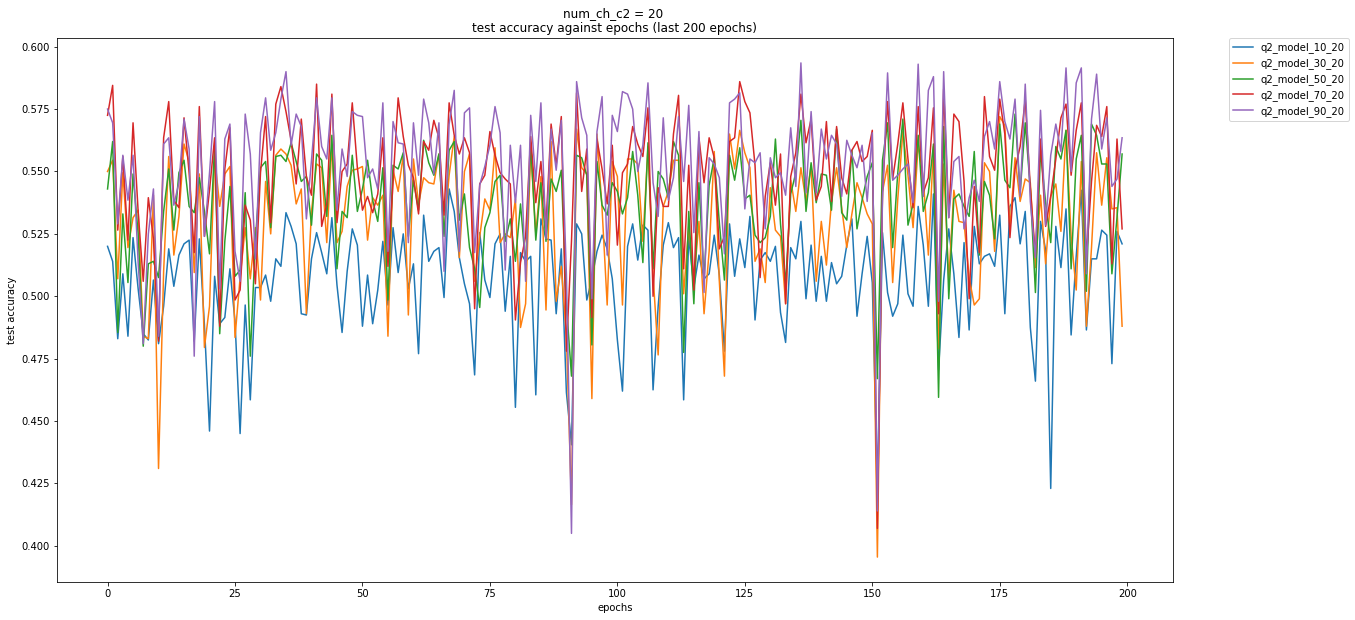

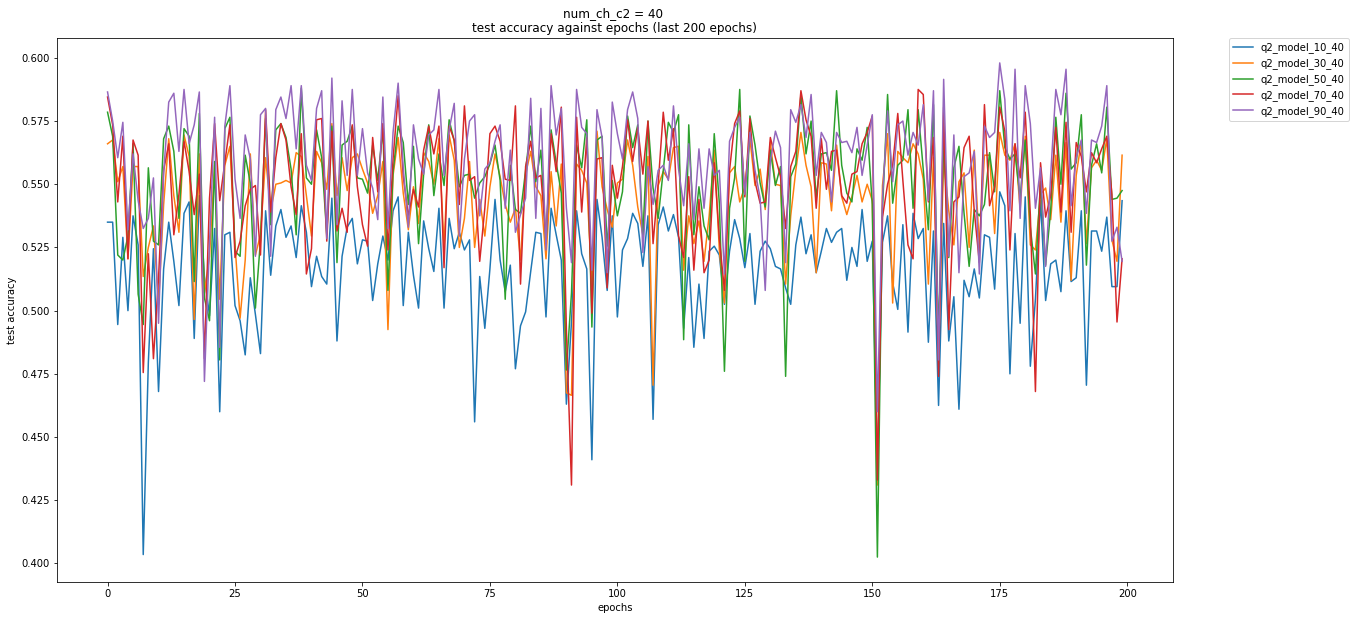

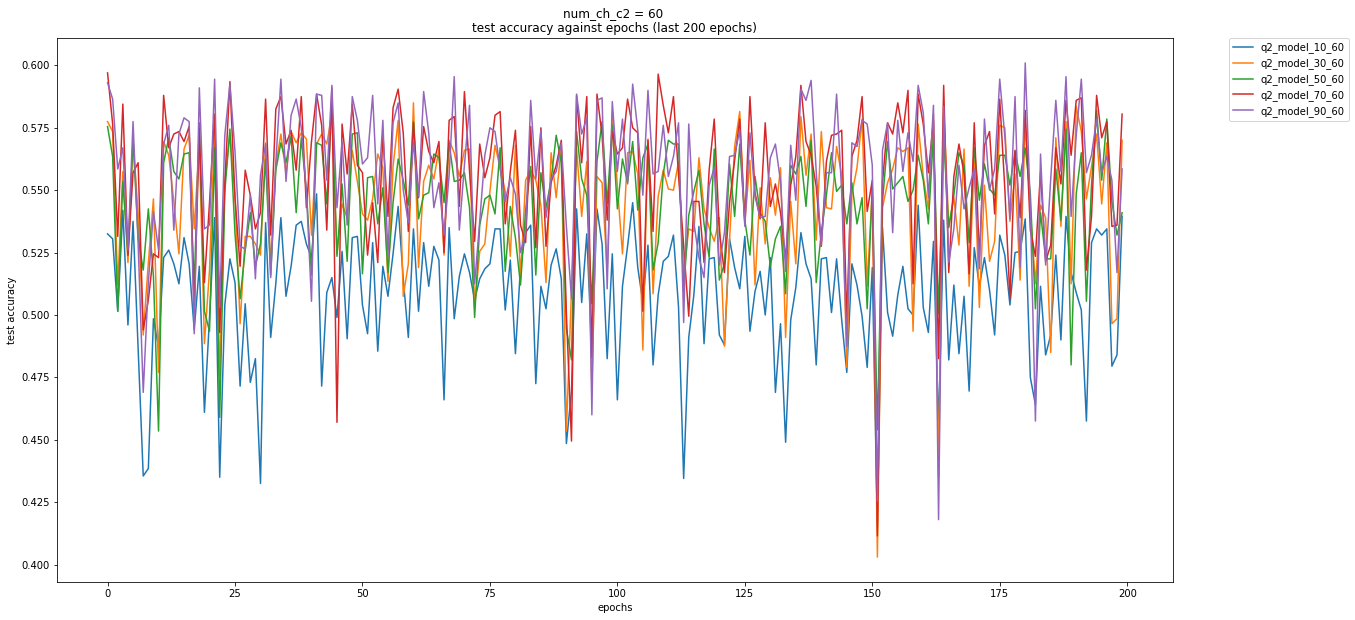

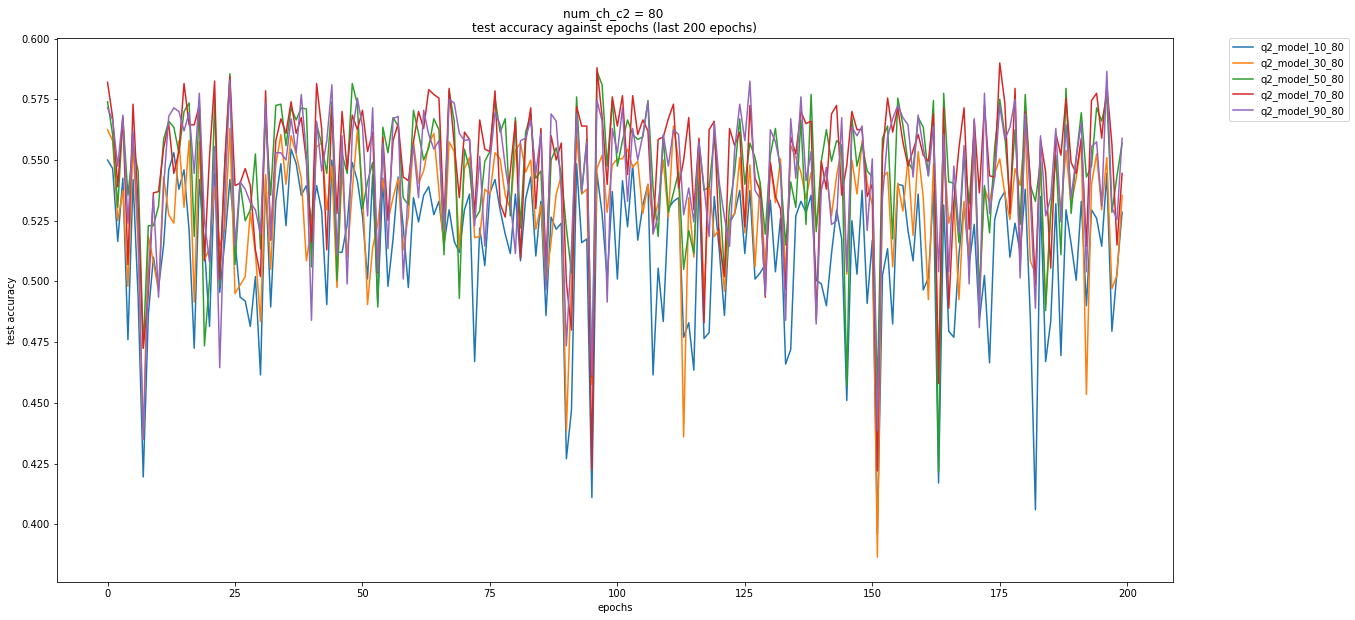

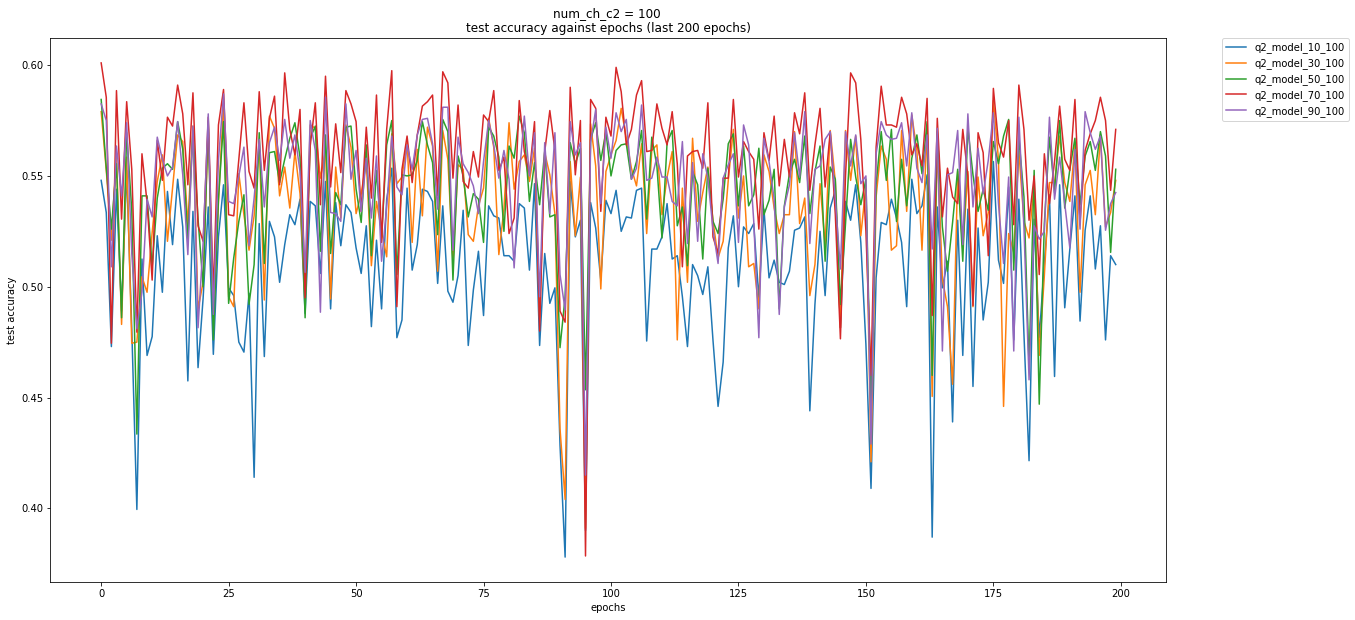

In [19]:
for i in range(5):
  num_ch_c2 = str(20*i + 20)
  filename = 'q4_compare_test_acc_num_ch_c2_' + num_ch_c2 + '_from_epoch_800'
  title = f'num_ch_c2 = {num_ch_c2} \ntest accuracy against epochs (last 200 epochs)'
  compare_test_acc(list_num_ch_c2[i], filename, 800, title=title)

### Compare across optimizers (including plain SGD)

In [20]:
dict_optimizer = {}
for model_name in ['q2_model_90_40', 'q3_model_90_40_SGD-momentum', 'q3_model_90_40_RMSProp', 'q3_model_90_40_Adam', 'q3_model_90_40_SGD_dropout']:
  dict_optimizer[model_name] = histories_json[model_name]
print(dict_optimizer.keys())

dict_keys(['q2_model_90_40', 'q3_model_90_40_SGD-momentum', 'q3_model_90_40_RMSProp', 'q3_model_90_40_Adam', 'q3_model_90_40_SGD_dropout'])


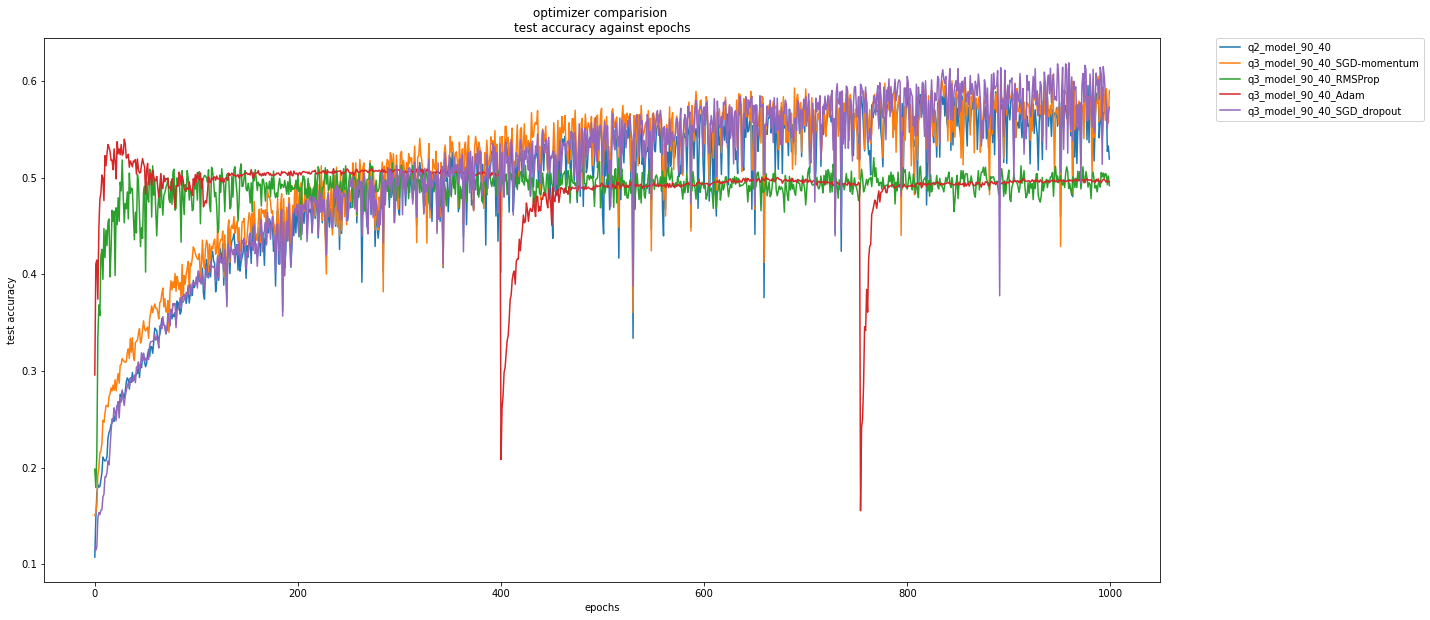

In [21]:
for i in range(1):
  filename = 'q4_compare_test_acc_optimizers'
  title = f'optimizer comparision \ntest accuracy against epochs'
  compare_test_acc(dict_optimizer, filename, title=title)

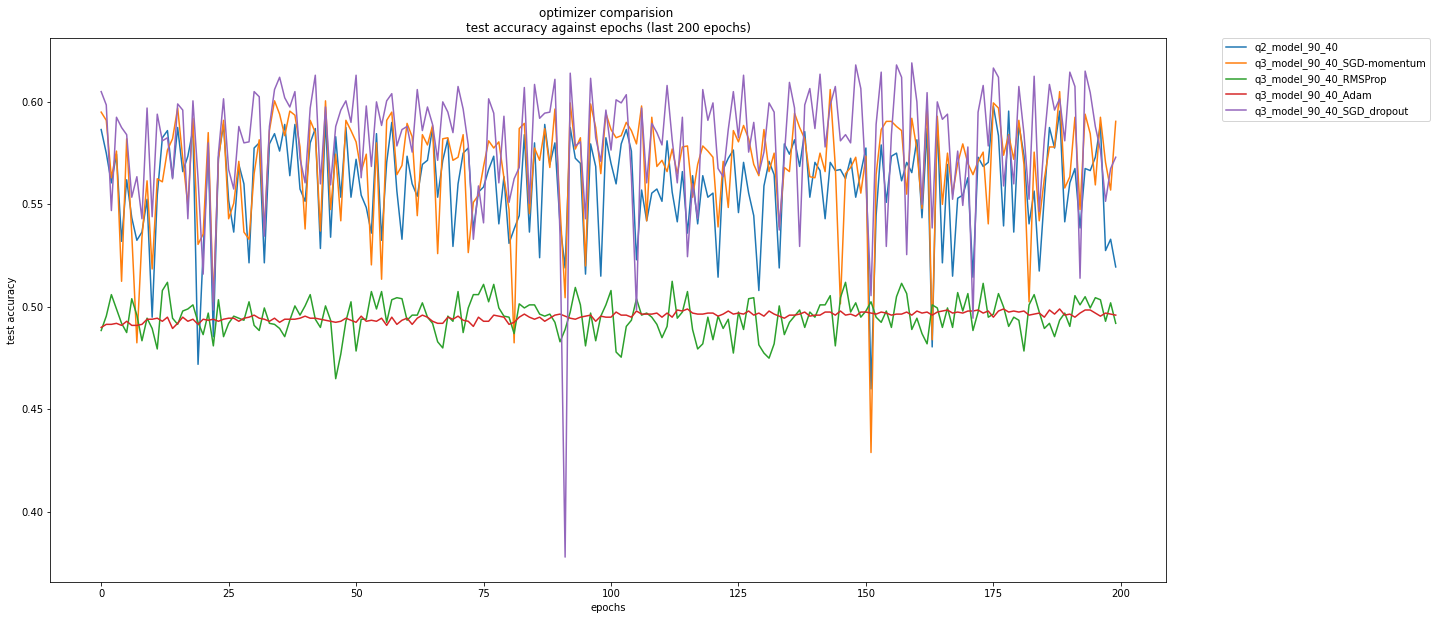

In [22]:
for i in range(1):
  filename = 'q4_compare_test_acc_optimizers'  + '_from_epoch_800'
  title = f'optimizer comparision \ntest accuracy against epochs (last 200 epochs)'
  compare_test_acc(dict_optimizer, filename, 800, title=title)

# Conclusion